In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|█████▍                                                        | 4371/50000 [00:00<00:01, 43703.79it/s]

 18%|██████████▉                                                   | 8849/50000 [00:00<00:00, 44332.24it/s]

 27%|████████████████▎                                            | 13333/50000 [00:00<00:00, 44562.54it/s]

 36%|█████████████████████▋                                       | 17810/50000 [00:00<00:00, 44643.19it/s]

 45%|███████████████████████████▏                                 | 22291/50000 [00:00<00:00, 44701.55it/s]

 54%|████████████████████████████████▋                            | 26762/50000 [00:00<00:00, 44691.00it/s]

 62%|██████████████████████████████████████                       | 31246/50000 [00:00<00:00, 44736.85it/s]

 71%|███████████████████████████████████████████▌                 | 35728/50000 [00:00<00:00, 44760.75it/s]

 80%|█████████████████████████████████████████████████            | 40207/50000 [00:00<00:00, 44768.27it/s]

 89%|██████████████████████████████████████████████████████▌      | 44707/50000 [00:01<00:00, 44838.23it/s]

 98%|████████████████████████████████████████████████████████████ | 49191/50000 [00:01<00:00, 44837.31it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44697.27it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 44%|███████████████████████████▎                                  | 4400/10000 [00:00<00:00, 43998.68it/s]

 89%|██████████████████████████████████████████████████████▉       | 8862/10000 [00:00<00:00, 44362.75it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43843.53it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 4bdq8c2h


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-4bdq8c2h:best, 58.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/625 [00:00<?, ?it/s]

  0%|                                                                      | 1/625 [00:00<05:43,  1.82it/s]

  3%|█▉                                                                   | 18/625 [00:00<00:16, 36.05it/s]

  5%|███▊                                                                 | 34/625 [00:00<00:09, 63.13it/s]

  8%|█████▌                                                               | 50/625 [00:00<00:06, 85.36it/s]

 10%|███████                                                             | 65/625 [00:00<00:05, 101.60it/s]

 13%|████████▊                                                           | 81/625 [00:01<00:04, 115.39it/s]

 16%|██████████▌                                                         | 97/625 [00:01<00:04, 125.78it/s]

 18%|████████████                                                       | 112/625 [00:01<00:03, 132.39it/s]

 20%|█████████████▋                                                     | 128/625 [00:01<00:03, 138.03it/s]

 23%|███████████████▍                                                   | 144/625 [00:01<00:03, 142.16it/s]

 26%|█████████████████▏                                                 | 160/625 [00:01<00:03, 145.43it/s]

 28%|██████████████████▊                                                | 176/625 [00:01<00:03, 148.82it/s]

 31%|████████████████████▌                                              | 192/625 [00:01<00:02, 150.26it/s]

 33%|██████████████████████▎                                            | 208/625 [00:01<00:02, 150.55it/s]

 36%|████████████████████████                                           | 224/625 [00:02<00:02, 151.39it/s]

 38%|█████████████████████████▋                                         | 240/625 [00:02<00:02, 151.54it/s]

 41%|███████████████████████████▍                                       | 256/625 [00:02<00:02, 151.85it/s]

 44%|█████████████████████████████▏                                     | 272/625 [00:02<00:02, 152.36it/s]

 46%|██████████████████████████████▊                                    | 288/625 [00:02<00:02, 152.34it/s]

 49%|████████████████████████████████▌                                  | 304/625 [00:02<00:02, 152.52it/s]

 51%|██████████████████████████████████▎                                | 320/625 [00:02<00:01, 153.98it/s]

 54%|████████████████████████████████████                               | 336/625 [00:02<00:01, 154.05it/s]

 56%|█████████████████████████████████████▋                             | 352/625 [00:02<00:01, 153.75it/s]

 59%|███████████████████████████████████████▍                           | 368/625 [00:02<00:01, 152.89it/s]

 61%|█████████████████████████████████████████▏                         | 384/625 [00:03<00:01, 152.79it/s]

 64%|██████████████████████████████████████████▉                        | 400/625 [00:03<00:01, 152.59it/s]

 67%|████████████████████████████████████████████▌                      | 416/625 [00:03<00:01, 152.37it/s]

 69%|██████████████████████████████████████████████▎                    | 432/625 [00:03<00:01, 152.59it/s]

 72%|████████████████████████████████████████████████                   | 448/625 [00:03<00:01, 152.58it/s]

 74%|█████████████████████████████████████████████████▋                 | 464/625 [00:03<00:01, 152.24it/s]

 77%|███████████████████████████████████████████████████▍               | 480/625 [00:03<00:00, 152.21it/s]

 79%|█████████████████████████████████████████████████████▏             | 496/625 [00:03<00:00, 152.43it/s]

 82%|██████████████████████████████████████████████████████▉            | 512/625 [00:03<00:00, 151.72it/s]

 84%|████████████████████████████████████████████████████████▌          | 528/625 [00:04<00:00, 151.93it/s]

 87%|██████████████████████████████████████████████████████████▎        | 544/625 [00:04<00:00, 151.96it/s]

 90%|████████████████████████████████████████████████████████████       | 560/625 [00:04<00:00, 151.61it/s]

 92%|█████████████████████████████████████████████████████████████▋     | 576/625 [00:04<00:00, 152.19it/s]

 95%|███████████████████████████████████████████████████████████████▍   | 592/625 [00:04<00:00, 152.52it/s]

 97%|█████████████████████████████████████████████████████████████████▏ | 608/625 [00:04<00:00, 152.01it/s]

100%|██████████████████████████████████████████████████████████████████▉| 624/625 [00:04<00:00, 152.18it/s]

100%|███████████████████████████████████████████████████████████████████| 625/625 [00:04<00:00, 134.20it/s]

train - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▉                                                                     | 2/157 [00:00<00:07, 19.40it/s]

 11%|███████▉                                                             | 18/157 [00:00<00:01, 97.80it/s]

 22%|██████████████▋                                                     | 34/157 [00:00<00:01, 122.82it/s]

 32%|█████████████████████▋                                              | 50/157 [00:00<00:00, 134.73it/s]

 42%|████████████████████████████▌                                       | 66/157 [00:00<00:00, 141.11it/s]

 52%|███████████████████████████████████▌                                | 82/157 [00:00<00:00, 145.00it/s]

 62%|██████████████████████████████████████████▍                         | 98/157 [00:00<00:00, 147.70it/s]

 73%|████████████████████████████████████████████████▋                  | 114/157 [00:00<00:00, 148.93it/s]

 83%|███████████████████████████████████████████████████████▍           | 130/157 [00:00<00:00, 150.23it/s]

 93%|██████████████████████████████████████████████████████████████▎    | 146/157 [00:01<00:00, 150.91it/s]

100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 131.28it/s]

val - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▍                                                                     | 1/157 [00:00<00:16,  9.60it/s]

 11%|███████▍                                                             | 17/157 [00:00<00:01, 93.63it/s]

 20%|█████████████▊                                                      | 32/157 [00:00<00:01, 118.47it/s]

 31%|████████████████████▊                                               | 48/157 [00:00<00:00, 133.83it/s]

 41%|███████████████████████████▋                                        | 64/157 [00:00<00:00, 141.14it/s]

 50%|██████████████████████████████████▏                                 | 79/157 [00:00<00:00, 144.04it/s]

 61%|█████████████████████████████████████████▏                          | 95/157 [00:00<00:00, 146.31it/s]

 71%|███████████████████████████████████████████████▎                   | 111/157 [00:00<00:00, 148.19it/s]

 81%|██████████████████████████████████████████████████████▏            | 127/157 [00:00<00:00, 149.48it/s]

 91%|█████████████████████████████████████████████████████████████      | 143/157 [00:01<00:00, 150.62it/s]

100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 134.86it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

 16%|██████████▉                                                         | 16/100 [00:00<00:00, 154.63it/s]

 32%|█████████████████████▊                                              | 32/100 [00:00<00:00, 153.74it/s]

 48%|████████████████████████████████▋                                   | 48/100 [00:00<00:00, 154.75it/s]

 64%|███████████████████████████████████████████▌                        | 64/100 [00:00<00:00, 154.97it/s]

 80%|██████████████████████████████████████████████████████▍             | 80/100 [00:00<00:00, 154.39it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 96/100 [00:00<00:00, 154.95it/s]

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 156.45it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(40000, 3, 32, 32) (40000, 3, 32, 32) (40000, 512) (40000, 10) (40000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(6400, 3, 32, 32) (6400, 3, 32, 32) (6400, 512) (6400, 10)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


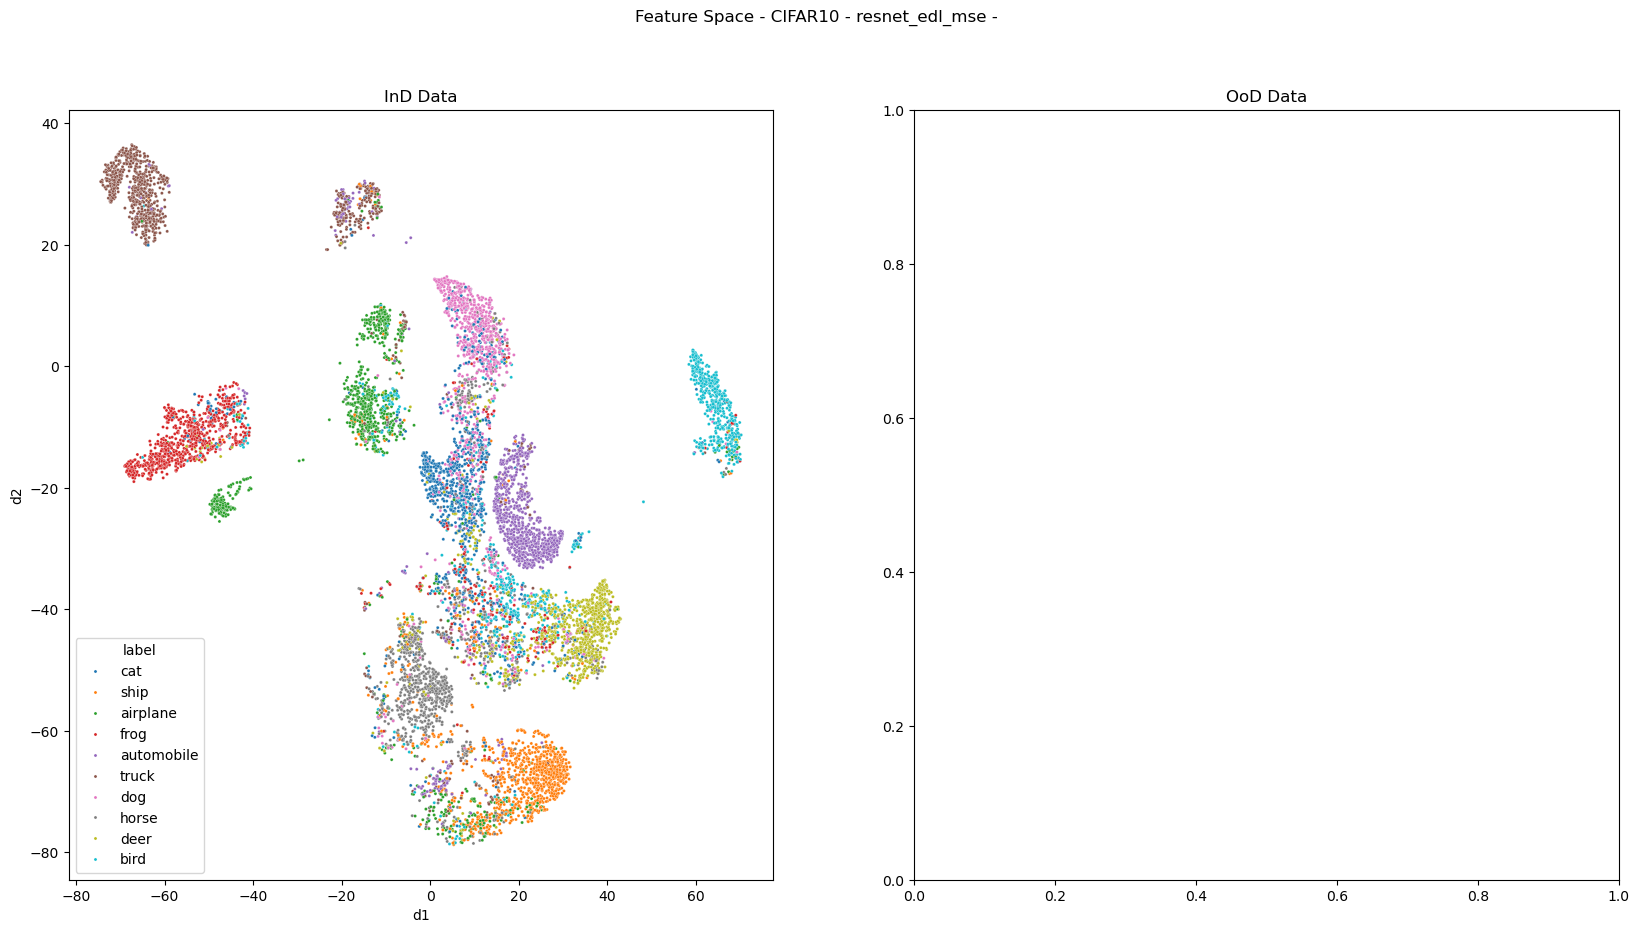

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

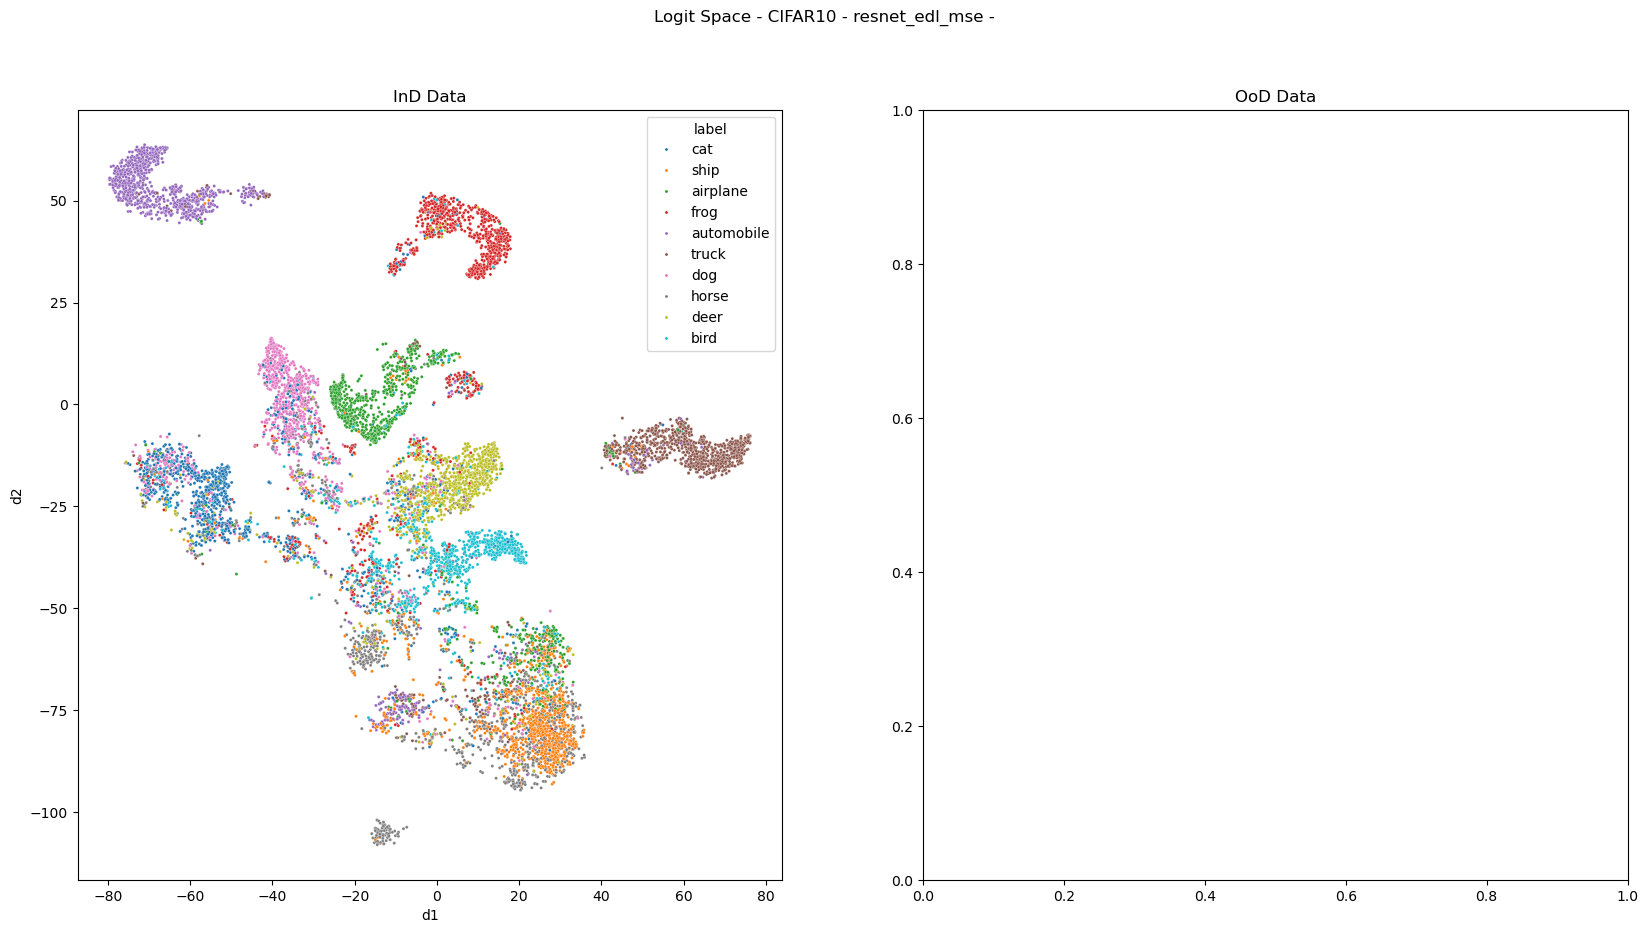

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:02,  1.32it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.32it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:02<00:00,  1.18it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]

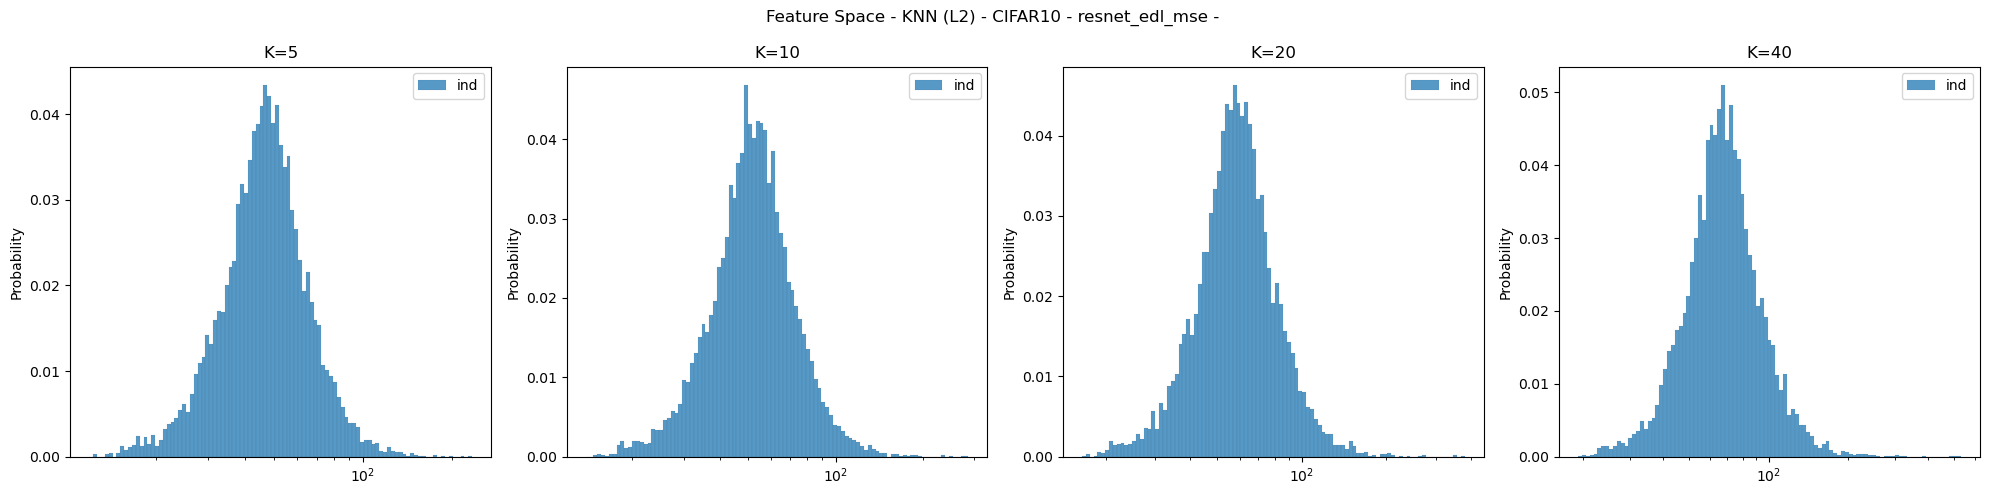

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:02,  1.36it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.35it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:02<00:00,  1.33it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.29it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.31it/s]

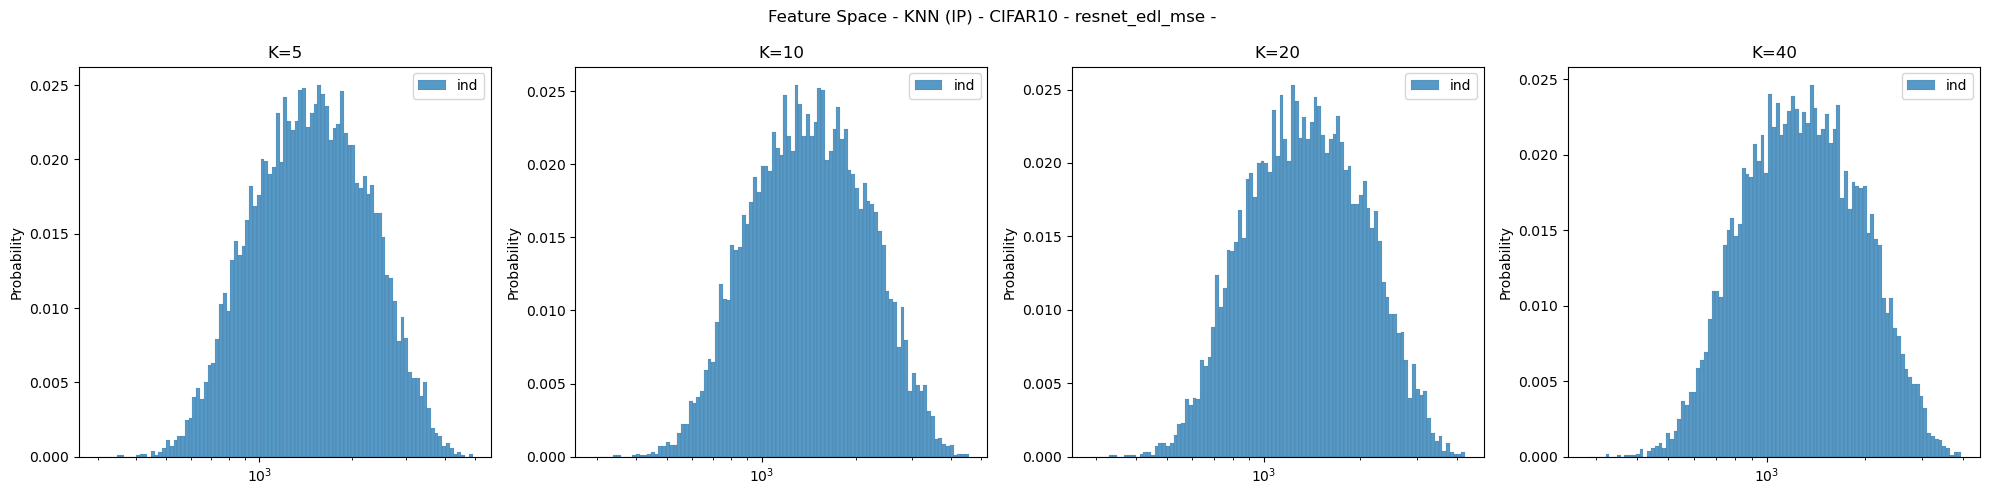

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  5.95it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  5.78it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  5.42it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  3.45it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.03it/s]

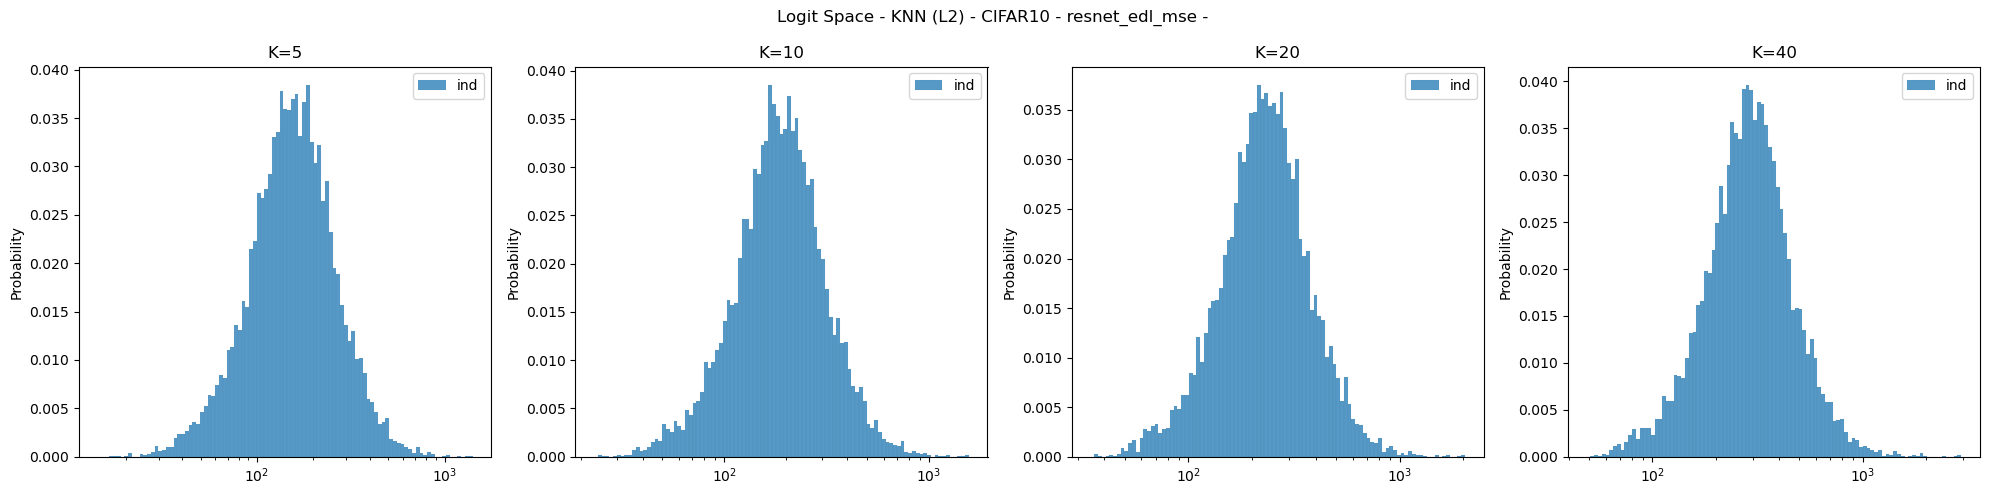

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  6.63it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  6.42it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  5.95it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.47it/s]

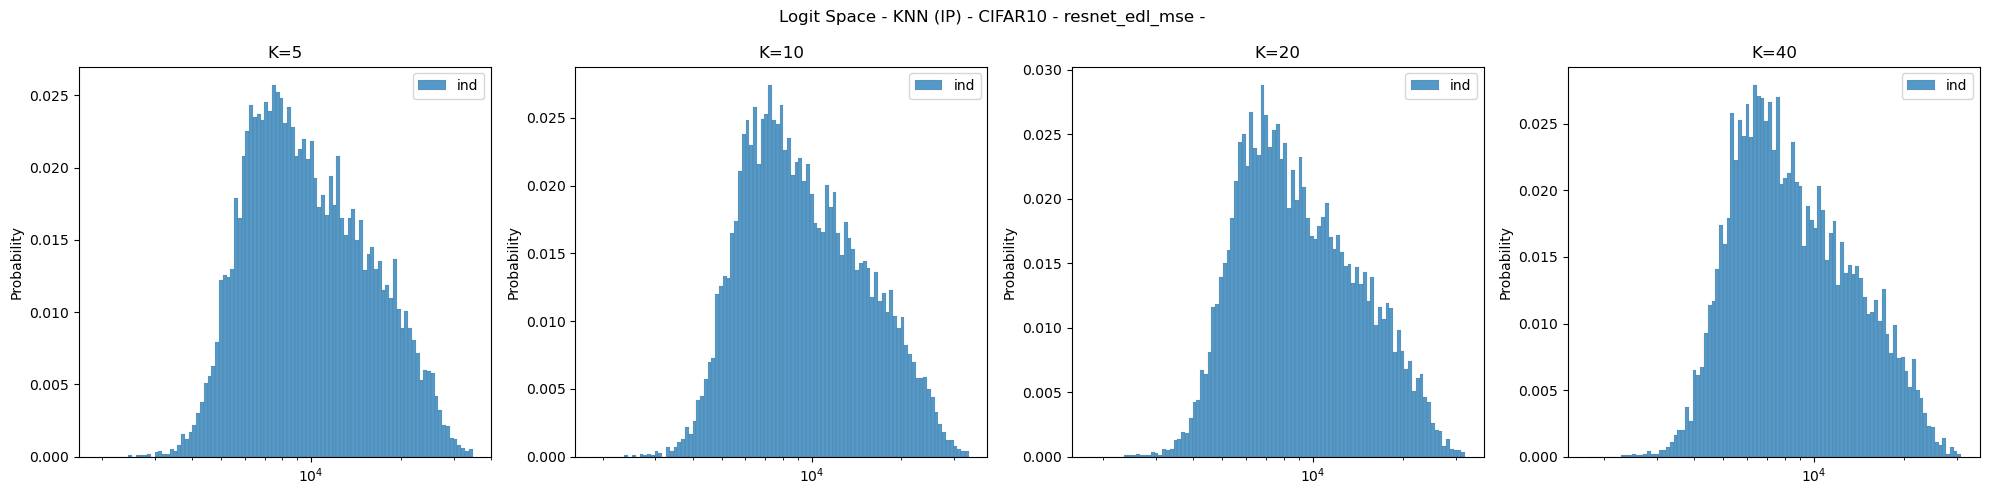

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_771238/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_771238/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)


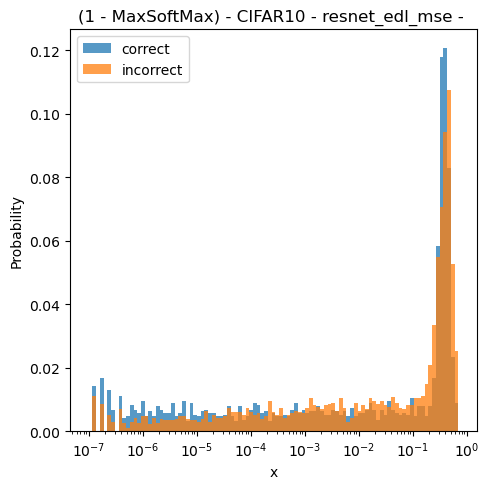

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

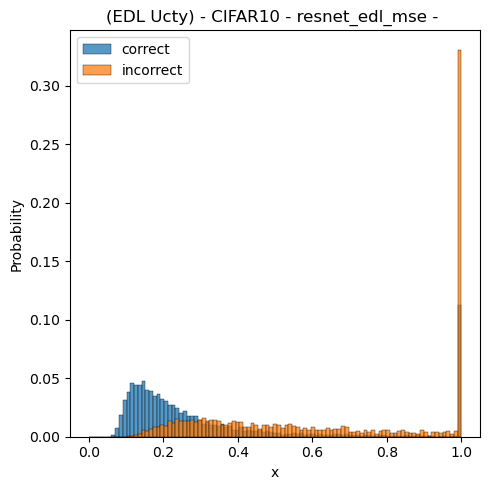

In [20]:
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

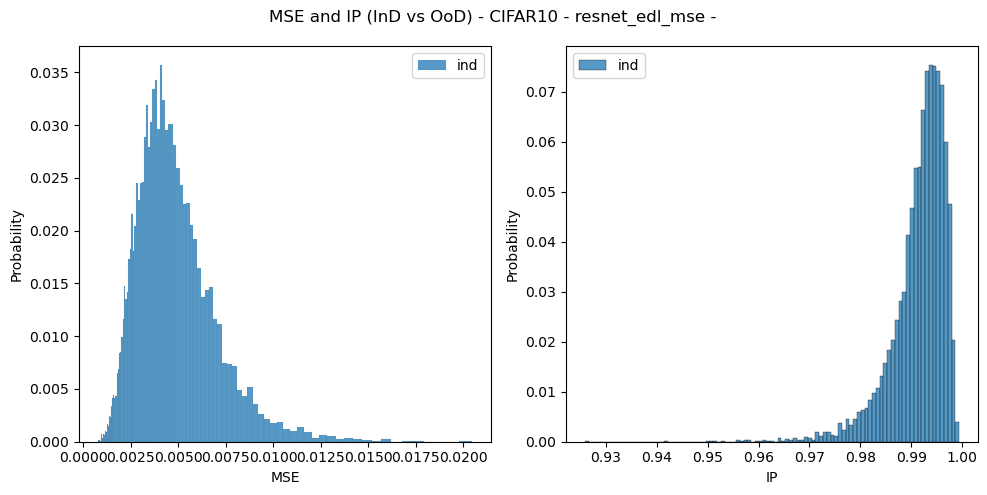

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()